# 2 way ANOVA

In [1]:
%matplotlib inline 
import pandas as pd
#from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
import argparse
import os,sys,inspect
import matplotlib.patches as mpatches #for the plot legend
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Read file into pandas dataframe using args in command line. For the notebook just hard-type the file and args

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--csv_file", required=True, help="The csv file with factors as columns and independent measurements (peptides) as rows")
parser.add_argument("--num_cat_f1", required=True, type=int, help="The number of levels/categories for factor 1")
parser.add_argument("--num_cat_f2", required=True, type=int, help="The number of levels/categories for factor 2")
parser.add_argument("--num_repl", required=True, type=int, help="The number of observations per each factor 1 x factor 2 combination")
#args = parser.parse_args()
#datafile = args.csv_file
datafile = "/home/vital/cyano/Quanti_PeptMatrix.csv"
datafile_basename = os.path.basename(datafile).split(".")[0]
if not os.path.isfile(datafile):
    print "\nFile not found: %s " % datafile + "\n"
#num_cat_f1 = args.num_cat_f1
num_cat_f1 = 3
#num_cat_f2 = args.num_cat_f2
num_cat_f2 = 8
#num_repl = args.num_repl
num_repl= 3

data = pd.read_csv(datafile)

#### The csv_file columns should be arranged as follows: 

F1L1_F2L1_R1\t...\tF1L1_F2L1_Rn\tF1L1_F2L2_R1\t... F1L1_F2L2_Rn	... F1Ln1_F2L1_R1 ... F1Ln1_F2L1_Rn	F1Ln1_F2Ln2_R1	... F1Ln1_F2Ln2_Rn

(F: Factor; L: Level; R: Replicate; n1: number of levels for F1; n2: number of levels for F2; n: number of replicates/observations)

Example:

Factor 1 is Cell_Line, has 2 levels: Melanoma, Colon

Factor 2 is Drug, has 3 levels: CT0, DTX, 5FU

There are 3 replicates/observations per each cell line x Drug combination 

The file columns should be:

Mel_CT0_1	Mel_CT0_2	Mel_CT0_3	Mel_DTX_1	Mel_DTX_2	Mel_DTX_3	Mel_5FU_1	Mel_5FU_2	Mel_5FU_3 Col_CT0_1	Col_CT0_2	Col_CT0_3	Col_DTX_1	Col_DTX_2	Col_DTX_3	Col_5FU_1	Col_5FU_2	Col_5FU_3


#### Calculate Degrees of Freedom:

In [3]:
def dof(peptide_df):
    N = len(peptide_df.dependent_variable)
    dof_factor_1 = len(peptide_df.factor_1.unique()) - 1
    dof_factor_2 = len(peptide_df.factor_2.unique()) - 1
    dof_factor_1_x_factor_2 = dof_factor_1*dof_factor_2 #interaction
    dof_w = N - (len(peptide_df.factor_1.unique())*len(peptide_df.factor_2.unique())) #within
    return(dof_factor_1, dof_factor_2, dof_factor_1_x_factor_2, dof_w)


#### Calculate Sum of Squares:

In [4]:
def ssq(data, grand_mean):
    #SUM of SQUARES FOR EACH FACTOR (Independent variables: factor_1 AND factor_2): 
    ssq_factor_1 = sum( [(data[data.factor_1 == f1_category].dependent_variable.mean() - grand_mean)**2 for f1_category in data.factor_1] )
    ssq_factor_2 = sum( [(data[data.factor_2 == f2_category].dependent_variable.mean() - grand_mean)**2 for f2_category in data.factor_2] )
    #TOTAL SUM OF SQUARES:
    ssq_t = sum((data.dependent_variable - grand_mean)**2)

    f1_dict = {f1_lvl: data[data.factor_1 == f1_lvl] for f1_lvl in data.factor_1.unique()}
    
    #For within group variation I need first to estimate means in each treatment group (treatment = each combination of the two factors, f1xf2_dict)
    f1xf2_dict = { k: [v[v.factor_2 == f2_c].dependent_variable.mean() for f2_c in v.factor_2] for k, v in f1_dict.iteritems()}

    #And GET SSQ_w
    ssq_w = 0
    for k in f1_dict.keys():
        ssq_w += sum((f1_dict[k].dependent_variable - f1xf2_dict[k])**2)

    #SUM OF SQUARES OF THE INTERACTION 
    ssq_factor_1_x_factor_2 = ssq_t-ssq_factor_1-ssq_factor_2-ssq_w
    return(ssq_factor_1, ssq_factor_2, ssq_t, ssq_w, ssq_factor_1_x_factor_2)

#### Calculate Mean Squares:

In [5]:
def msq(ssq_factor_1, ssq_factor_2, ssq_factor_1_x_factor_2, ssq_w, dof_factor_1, dof_factor_2, dof_factor_1_x_factor_2, dof_w):
    msq_factor_1 = ssq_factor_1 / dof_factor_1
    msq_factor_2 = ssq_factor_2 / dof_factor_2
    msq_factor_1_x_factor_2 = ssq_factor_1_x_factor_2 / dof_factor_1_x_factor_2 #INTERACTION
    msq_w = ssq_w/dof_w #WITHIN
    return(msq_factor_1, msq_factor_2, msq_factor_1_x_factor_2, msq_w)

#### Calculate F-ratio: 

The F-statistic is simply the mean square for each effect and the interaction divided by the mean square for within (error/residual).

In [6]:
def f_ratio(msq_factor_1, msq_factor_2, msq_factor_1_x_factor_2, msq_w):
    f_factor_1 = msq_factor_1/msq_w
    f_factor_2 = msq_factor_2/msq_w
    f_factor_1_x_factor_2 = msq_factor_1_x_factor_2/msq_w
    return(f_factor_1, f_factor_2, f_factor_1_x_factor_2)

Create pandas sub-dataframe for each peptide (row in original dataframe)
with columns intensity, cell_line, and drug 

In [7]:
print("\nEstimating p-values\n")


Estimating p-values



In [8]:
for index, row in data.iterrows():
    #Get pandas df for each peptide with columns dependent_variable, factor_1 and factor_2:
    peptide_df = pd.DataFrame(columns=["dependent_variable", "factor_1", "factor_2"])
    peptide_df.factor_1 = [ "f1_%s"%cat_f1 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
    peptide_df.factor_2 = [ "f2_%s"%cat_f2 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
    peptide_df.dependent_variable = row.values[1:]
    #get Degrees of Freedom
    dof_factor_1, dof_factor_2, dof_factor_1_x_factor_2, dof_w = dof(peptide_df)
    #get grand mean Using Pandas DataFrame method mean on the dependent variable only
    grand_mean = peptide_df.dependent_variable.mean() #which is simply the mean of all values
    #Calculate sum of squares
    ssq_factor_1, ssq_factor_2, ssq_t, ssq_w, ssq_factor_1_x_factor_2 = ssq(peptide_df, grand_mean)
    #Calculate mean squares
    msq_factor_1, msq_factor_2, msq_factor_1_x_factor_2, msq_w = msq(ssq_factor_1, ssq_factor_2, ssq_factor_1_x_factor_2, ssq_w, dof_factor_1, dof_factor_2, dof_factor_1_x_factor_2, dof_w)
    #Calculate F-ratio (F-satistic)
    f_factor_1, f_factor_2, f_factor_1_x_factor_2 = f_ratio(msq_factor_1, msq_factor_2, msq_factor_1_x_factor_2, msq_w)
    #OBTAIN p-values
    #scipy.stats method f.sf checks if the obtained F-ratios are above the critical value. 
    #Use F-value for each effect and interaction as well as the degrees of freedom for them, and the degree of freedom within.
    #Null Hypothesis 1:  H0: no difference in means among the groups in factor 1
    p_factor_1 = stats.f.sf(f_factor_1, dof_factor_1, dof_w)
    #Null Hypothesis 2:  H0: no difference in means among the groups in factor 2
    p_factor_2 = stats.f.sf(f_factor_2, dof_factor_2, dof_w)
    #Null Hypothesis 3:  H0: cell-lines do not interact with factor_2s in the response
    p_factor_1_x_factor_2 = stats.f.sf(f_factor_1_x_factor_2, dof_factor_1_x_factor_2, dof_w)
    #ADD rows to the original pandas df with the three pvalues:
    data.loc[index, 'p_factor_1'] = p_factor_1
    data.loc[index, 'p_factor_2'] = p_factor_2
    data.loc[index, 'p_factor_1_x_factor_2'] = p_factor_1_x_factor_2

Create new data set with the extra columns with the p-values

In [9]:
data.to_csv("../Quanti_PeptMatrix_p.csv")
#then read it
data = pd.read_csv("../Quanti_PeptMatrix_p.csv")

#### Histograms of the p values
Remove NaNs or hist won't work

p values Factor_1

<function matplotlib.pyplot.show>

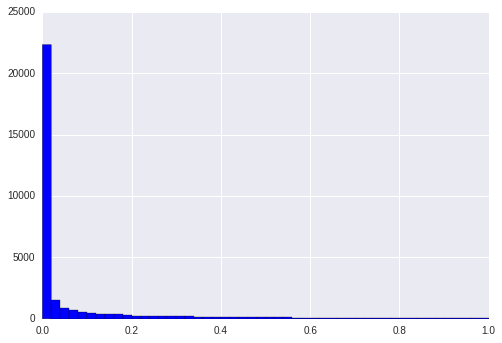

In [10]:
factor1_pval_fig = plt.hist(data.p_factor_1.dropna(), color='blue', bins=50)
plt.savefig("../img/p_value_cell_line.pdf")
#plt.clf()
plt.show

p values Factor 2

<function matplotlib.pyplot.show>

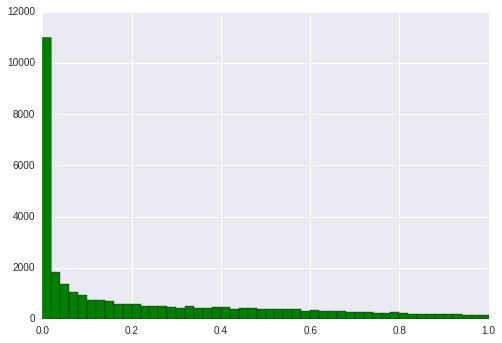

In [11]:
factor2_pval_fig = plt.hist(data.p_factor_2.dropna(), color='green', bins=50)
plt.savefig("../img/p_value_drug.pdf")
plt.show

<function matplotlib.pyplot.show>

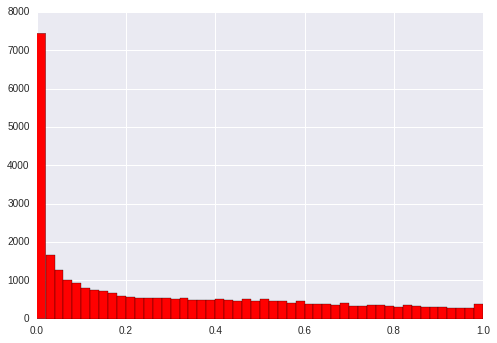

In [12]:
interaction_pval_fig = plt.hist(data.p_factor_1_x_factor_2.dropna(), color='red', bins=50)
plt.savefig("../img/p_value_interaction.pdf")
plt.show

#### Bar Plot p-values

([<matplotlib.axis.XTick at 0x7f0897549750>,
 <a list of 3 Text xticklabel objects>)

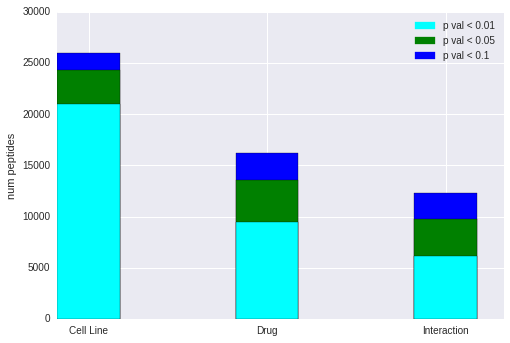

In [13]:
data = pd.read_csv("../Quanti_PeptMatrix_p.csv")
                   
groups=["Cell Line", "Drug", "Interaction"]
n=len(groups)

f1_p001 = len(data[data.p_factor_1 < 0.01])
f1_p005 = len(data[data.p_factor_1 < 0.05])
f1_p01 = len(data[data.p_factor_1 < 0.1])
f2_p001 = len(data[data.p_factor_2 < 0.01])
f2_p005 = len(data[data.p_factor_2 < 0.05])
f2_p01 = len(data[data.p_factor_2 < 0.1])
f1xf2_p001 = len(data[data.p_factor_1_x_factor_2 < 0.01])
f1xf2_p005 = len(data[data.p_factor_1_x_factor_2 < 0.05])
f1xf2_p01 = len(data[data.p_factor_1_x_factor_2 < 0.1])


p_001 = np.array([f1_p001, f2_p001, f1xf2_p001])
p_005 = np.array([f1_p005, f2_p005, f1xf2_p005])
p_01 = np.array([f1_p01, f2_p01, f1xf2_p01])

ind=np.arange(n)
width=0.35

p01 = plt.bar(ind, p_01, width, color="blue")
p005 = plt.bar(ind, p_005, width, color="green")
p001 = plt.bar(ind, p_001, width, color="cyan")

cyan_patch = mpatches.Patch(color='cyan', label='p val < 0.01')
green_patch = mpatches.Patch(color='green', label='p val < 0.05')
blue_patch = mpatches.Patch(color='blue', label='p val < 0.1')

plt.legend(handles=[cyan_patch, green_patch, blue_patch])

plt.ylabel("num peptides")

plt.xticks(ind+width/2,("Cell Line", "Drug", "Interaction"))
#plt.clf()

RECALCULATE p-values AS q-values 

(https://github.com/nfusi/qvalue )

calculates pi0 and q_values as suggested in Storey and Tibshirani, 2003

In [14]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir + '/src') 
import qvalue #put __init__.py in lib folder and qvalue.py in same folder as  2wayANOVA.py

q_factor_1 = qvalue.estimate(data.p_factor_1)
q_factor_2 = qvalue.estimate(data.p_factor_2)
q_factor_1_x_factor_2 = qvalue.estimate(data.p_factor_1_x_factor_2)

And write new columns with q values

In [15]:
data['q_factor_1'] = q_factor_1
data['q_factor_2'] = q_factor_2
data['q_factor_1_x_factor_2'] = q_factor_1_x_factor_2

And write again the data to csv:

In [16]:
data.to_csv("../Quanti_PeptMatrix_p_q.csv")

#### Plot q-values

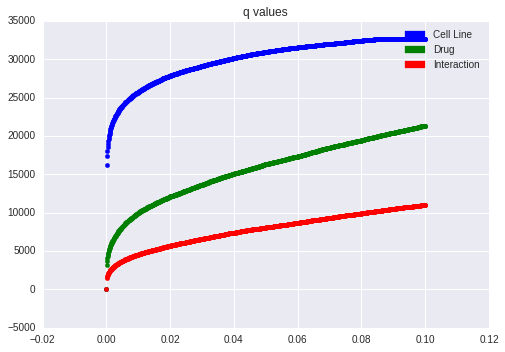

In [17]:
data = pd.read_csv("../Quanti_PeptMatrix_p_q.csv")

bins = np.linspace(0,0.1,1000)

freq_q_factor_1 = {}
for i in bins:
    freq_q_factor_1[round(i,4)] = sum(1 for qval in list(data.q_factor_1) if float(qval) < i)
plt.scatter(freq_q_factor_1.keys(), freq_q_factor_1.values(), color='blue')

freq_q_factor_2 = {}
for i in bins:
    freq_q_factor_2[round(i,4)] = sum(1 for qval in list(data.q_factor_2) if float(qval) < i)
plt.scatter(freq_q_factor_2.keys(), freq_q_factor_2.values(), color='green')

freq_q_interaction = {}
for i in bins:
    freq_q_interaction[round(i,4)] = sum(1 for qval in list(data.q_factor_1_x_factor_2) if float(qval) < i)
plt.scatter(freq_q_interaction.keys(), freq_q_interaction.values(), color='red')


plt.title("q values")
blue_patch = mpatches.Patch(color='blue', label='Cell Line')
green_patch = mpatches.Patch(color='green', label='Drug')
red_patch = mpatches.Patch(color='red', label='Interaction')
plt.legend(handles=[blue_patch, green_patch, red_patch])
plt.show()

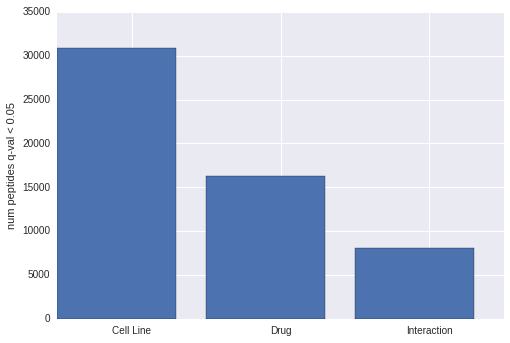

In [18]:
f1_q005 = len(data[data.q_factor_1 < 0.05]) 

f2_q005 = len(data[data.q_factor_2 < 0.05]) 

f1_f2_q005 = len(data[data.q_factor_1_x_factor_2 < 0.05]) 
plt.bar([1,2,3], [f1_q005, f2_q005, f1_f2_q005])
plt.xticks([1.5, 2.5, 3.5],("Cell Line","Drug", "Interaction"))
plt.ylabel("num peptides q-val < 0.05")
plt.show()
#plt.savefig("num_peptides_q005.pdf")